# Imports

In [10]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append(CODE_DIR)
sys.path.append(f"{CODE_DIR}/analysis")

In [11]:
import os
import torch
import numpy as np
import pandas as pd
import pickle

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()

# c_cycler, cmap
from plot_utils import *

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
from analysis.bda_models.bda_pixel_model_mnist import GenPixelModelMNIST
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from dataset_dataloader import get_n_data_samples_x_y

In [3]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/MNIST_surprisal_values.pt"

SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/MNIST_surprisal_dp_mixtures.pt"

SAVE_DP_COMP_KL_DISTS_FILE = f"{SAVE_DIR}/MNIST_dp_mixtures_kl_comp_dists.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
FIT_AND_COMPUTE_SURPRISAL_VALS = True

PERFORM_MODEL_CHECKS = False

In [5]:
run_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
run_df = run_df[run_df.image_or_language == "image"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(run_df.index)) \
                                  & (global_stats_df.phase == "valid")]

print(len(run_df), len(global_stats_df))
run_df.head()

66 66


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


# Get some MNIST data

In [6]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    N_DATA_SAMPLES = 1000

    train_x, train_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                              N_samples=N_DATA_SAMPLES, phase="train")
    valid_x, valid_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                              N_samples=N_DATA_SAMPLES, phase="valid")

    VALID_OBS_X = valid_x.flatten(start_dim=1).numpy()
    VALID_OBS_Y = valid_y.long().numpy()

    TRAIN_OBS_X = train_x.flatten(start_dim=1).numpy()
    TRAIN_OBS_Y = train_y.long().numpy()

**** BMNIST
**** BMNIST


# Generative Pixel Model MNIST (train & validation)

The generative model is a DP Mixture beta bernoulli model with 10 components (for the 10 digits).

In [7]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    NUM_SAMPLES = 1000

    # No need to pass chains and warmup because it is an exact model
    gen_model = GenPixelModelMNIST(
        obs_x=TRAIN_OBS_X, 
        obs_y=TRAIN_OBS_Y, 
        num_samples=NUM_SAMPLES, 
    )

I0210 16:47:35.233824 23449316097792 tpu_client.py:54] Starting the local TPU driver.
I0210 16:47:35.238811 23449316097792 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0210 16:47:35.240019 23449316097792 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
I0210 16:47:35.243738 23449316097792 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


# Gather samples from disk

In [8]:
if FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:

    EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
    
    SAMPLE_FILE = f"generative-samples.pt"
    CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

    MAX_SAMPLES_PER_MODEL = 500 # 500 is currently its max

    model_samples = dict()

    for idx, run_name in enumerate(os.listdir(EXPORT_DIR)):
        if run_name in run_df.run_name.values:
            
            clean_name = run_df[run_df.run_name == run_name].index.values[0]
            save_dir = f"{EXPORT_DIR}/{run_name}"
            
            if (os.path.exists(f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}") and os.path.exists(f"{save_dir}/{SAMPLE_FILE}")):
                # Dict with keys conditional_x, conditional_y
                conditional_samples = torch.load(f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}")["valid"]
                unconditional_samples = torch.load(f"{save_dir}/{SAMPLE_FILE}")

                conditional_x = conditional_samples["cond_sample_x"]
                condition_y = conditional_samples["original_y"]
                unconditional_x = unconditional_samples["x"]

                if len(conditional_x) < MAX_SAMPLES_PER_MODEL:
                    print(f"not enough conditional_x samples {len(conditional_x)} < {MAX_SAMPLES_PER_MODEL}")

                if len(unconditional_x) < MAX_SAMPLES_PER_MODEL:
                    print(f"not enough unconditional_x samples {len(unconditional_x)} < {MAX_SAMPLES_PER_MODEL}")

                model_samples[clean_name] = dict(
                    unconditional_x=unconditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
                    conditional_x=conditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
                    condition_y=condition_y[:MAX_SAMPLES_PER_MODEL].long().numpy()
                )

                print(idx, clean_name)
                print("unconditional_x", model_samples[clean_name]["unconditional_x"].shape)
                print("conditional_x", model_samples[clean_name]["conditional_x"].shape)
                print("condition_y", model_samples[clean_name]["condition_y"].shape, end='\n\n')
                
            else:
                print("Files missing, skip.")

    model_samples["data_group"] = dict(
        unconditional_x=VALID_OBS_X,
        conditional_x=VALID_OBS_X,
        condition_y=VALID_OBS_Y)


30 FB-VAE 40 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

31 FB-VAE 32 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

32 FB-VAE 24 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

35 FB-VAE 16 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

36 FB-VAE 4 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

37 FB-VAE 8 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

38 FB-VAE 40 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

39 FB-VAE 32 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

40 FB-VAE 24 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

41 FB-VAE 8 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

42 FB-VAE 4 dec: PixelC

## Collect & plot some posterior predictive samples

In [9]:
if PERFORM_MODEL_CHECKS:

    ncols = 5
    nrows = 2
    nplots = nrows * ncols

    for digit in range(10):
        obs_ys = np.ones(nplots).astype(int) * digit
        rng_key, rng_key_ = random.split(gen_model.rng_key)
        cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=obs_ys).sample(key=rng_key_)

        fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

        for i in range(nplots): 
            c = i % ncols
            r = i // ncols
            ax[r, c].imshow(np.array(cond_posterior_pred[i].reshape(28, 28)), cmap="Greys")
            ax[r, c].grid("off")
            ax[r, c].set_xticks([])
            ax[r, c].set_yticks([])

        plt.show()

# Sample from conditional posterior predictive

In [10]:
if PERFORM_MODEL_CHECKS:
    npost_samples = 100
    samples = dict()

    for digit in range(10):
        print(f"{digit:2d}/10", end="\r")
        valid_y_digit = VALID_OBS_Y[VALID_OBS_Y == digit]
        rng_key, rng_key_ = random.split(gen_model.rng_key)

        # N_post_samples, N_data, 784
        cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=valid_y_digit).sample(
            key=rng_key_, sample_shape=(npost_samples,))

        samples[digit] = cond_posterior_pred

# Plot true versus sampled digit

In [11]:
if PERFORM_MODEL_CHECKS:
    fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(3*3, 3*10))

    for k in range(10):
        # 2D [N, 786]
        true_digits = VALID_OBS_X[VALID_OBS_Y == k]
        avg_true_digit = true_digits.mean(axis=0)

        # 3D [S, N, 786]
        sampeld_digits = samples[k]
        avg_sampled_digit = sampeld_digits.mean(axis=0).mean(axis=0)

        ax[k, 0].imshow(avg_true_digit.reshape(28, 28), cmap="Greys")
        ax[k, 0].set_title(f"Avg. true digit {k}")
        ax[k, 1].imshow(avg_sampled_digit.reshape(28, 28), cmap="Greys")
        ax[k, 1].set_title(f"Avg. sampled digit {k}")
        ax[k, 2].imshow(np.abs(avg_true_digit-avg_sampled_digit).reshape(28, 28), cmap="Greys")
        ax[k, 2].set_title(f"Abs dif. between\navg. true and sampled digit {k}")

        for i in range(3):
            ax[k, i].grid("off")
            ax[k, i].set_xticks([])
            ax[k, i].set_yticks([])


# Posterior predictive checks

In [12]:

if PERFORM_MODEL_CHECKS:
    fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(3*4, 2*10))

    hist_kwargs = dict(bins=30, density=True, alpha=0.8)
    line_kwargs = dict(linestyle='--')

    for k in range(10):
        print(f"{k:2d}/10", end="\r")

        # 2D [N, 786]
        true_digits = VALID_OBS_X[VALID_OBS_Y == k]

        # 3D [S, N, 786]
        sampled_digits = samples[k]
        sampled_digits_2d = sampled_digits.reshape(-1, 28*28)

        # Hist of pixel means (hist over all pixels)
        ax[k, 0].hist(sampled_digits_2d.mean(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 0].hist(true_digits.mean(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 0].axvline(np.mean(sampled_digits_2d.mean(axis=0)), **line_kwargs, color="royalblue")
        ax[k, 0].axvline(np.mean(true_digits.mean(axis=0)), **line_kwargs, color="limegreen")
        ax[k, 0].set_xlabel(f'E[Y{k}]')

        # Hist of pixel std (hist over all pixels)
        ax[k, 1].hist(sampled_digits_2d.std(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 1].hist(true_digits.std(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 1].axvline(np.mean(sampled_digits_2d.std(axis=0)), **line_kwargs, color="royalblue")
        ax[k, 1].axvline(np.mean(true_digits.std(axis=0)), **line_kwargs, color="limegreen")
        ax[k, 1].set_xlabel(f'std[Y{k}]')

        # Hist of pixel std (hist over all pixels)
        ax[k, 2].hist(np.median(sampled_digits_2d, axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
        ax[k, 2].hist(np.median(true_digits, axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
        ax[k, 2].axvline(np.mean(np.median(sampled_digits_2d, axis=0)), **line_kwargs, color="royalblue")
        ax[k, 2].axvline(np.mean(np.median(true_digits, axis=0)), **line_kwargs, color="limegreen")
        ax[k, 2].set_xlabel(f'median[Y{k}]')

        if k == 0:
            ax[k, 2].legend(loc=(-0.5, 1.05))

        true_digits_unsqueeze = true_digits[None, :, :]

        # true_digits_unsqueeze: [1, N, D]
        # sampled_digits: [S, N, D]
        # pvals: [N, D]
        pvals = (sampled_digits > true_digits_unsqueeze).mean(axis=0)
        pvals = pvals.flatten()

        pvals_avg = pvals.mean()
        ax[k, 3].hist(pvals, **hist_kwargs, color="tab:orange", label="hist. over N x D")
        ax[k, 3].axvline(pvals_avg, **line_kwargs, color="black")
        ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')

        if k == 0:
            ax[k, 3].legend(loc=(0.0, 1.05))

    plt.tight_layout()

# Assess surprisal of model samples under generative model

In [9]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:

    surprisal_values = dict()

    for idx, (run_name, samples) in enumerate(model_samples.items()):
        print(f"{idx:2d}/{len(model_samples.keys())}", end='\r')

        unconditional_unconditional = - gen_model.assess_unconditional_posterior_predictive(samples["unconditional_x"])
        unconditional_conditional = - gen_model.assess_unconditional_posterior_predictive(samples["conditional_x"])
        conditional_conditional = - gen_model.conditional_posterior_predictive(samples["condition_y"]).log_prob(samples["conditional_x"])

        surprisal_values[run_name] = dict(
            unconditional_unconditional=unconditional_unconditional,
            unconditional_conditional=unconditional_conditional,
            conditional_conditional=conditional_conditional
        )

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)

else:
    if os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)
    else:
        print(f"No path SAVE_BDA_SURPRISAL_VALS_FILE={SAVE_BDA_SURPRISAL_VALS_FILE}, run with "
              "FIT_AND_COMPUTE_SURPRISAL_VALS=True to fit and compute surprisal values")


# Plot surprisal distribution and add global statistics

Rows: 66, cols: 3, every: 1, n_groups: 66


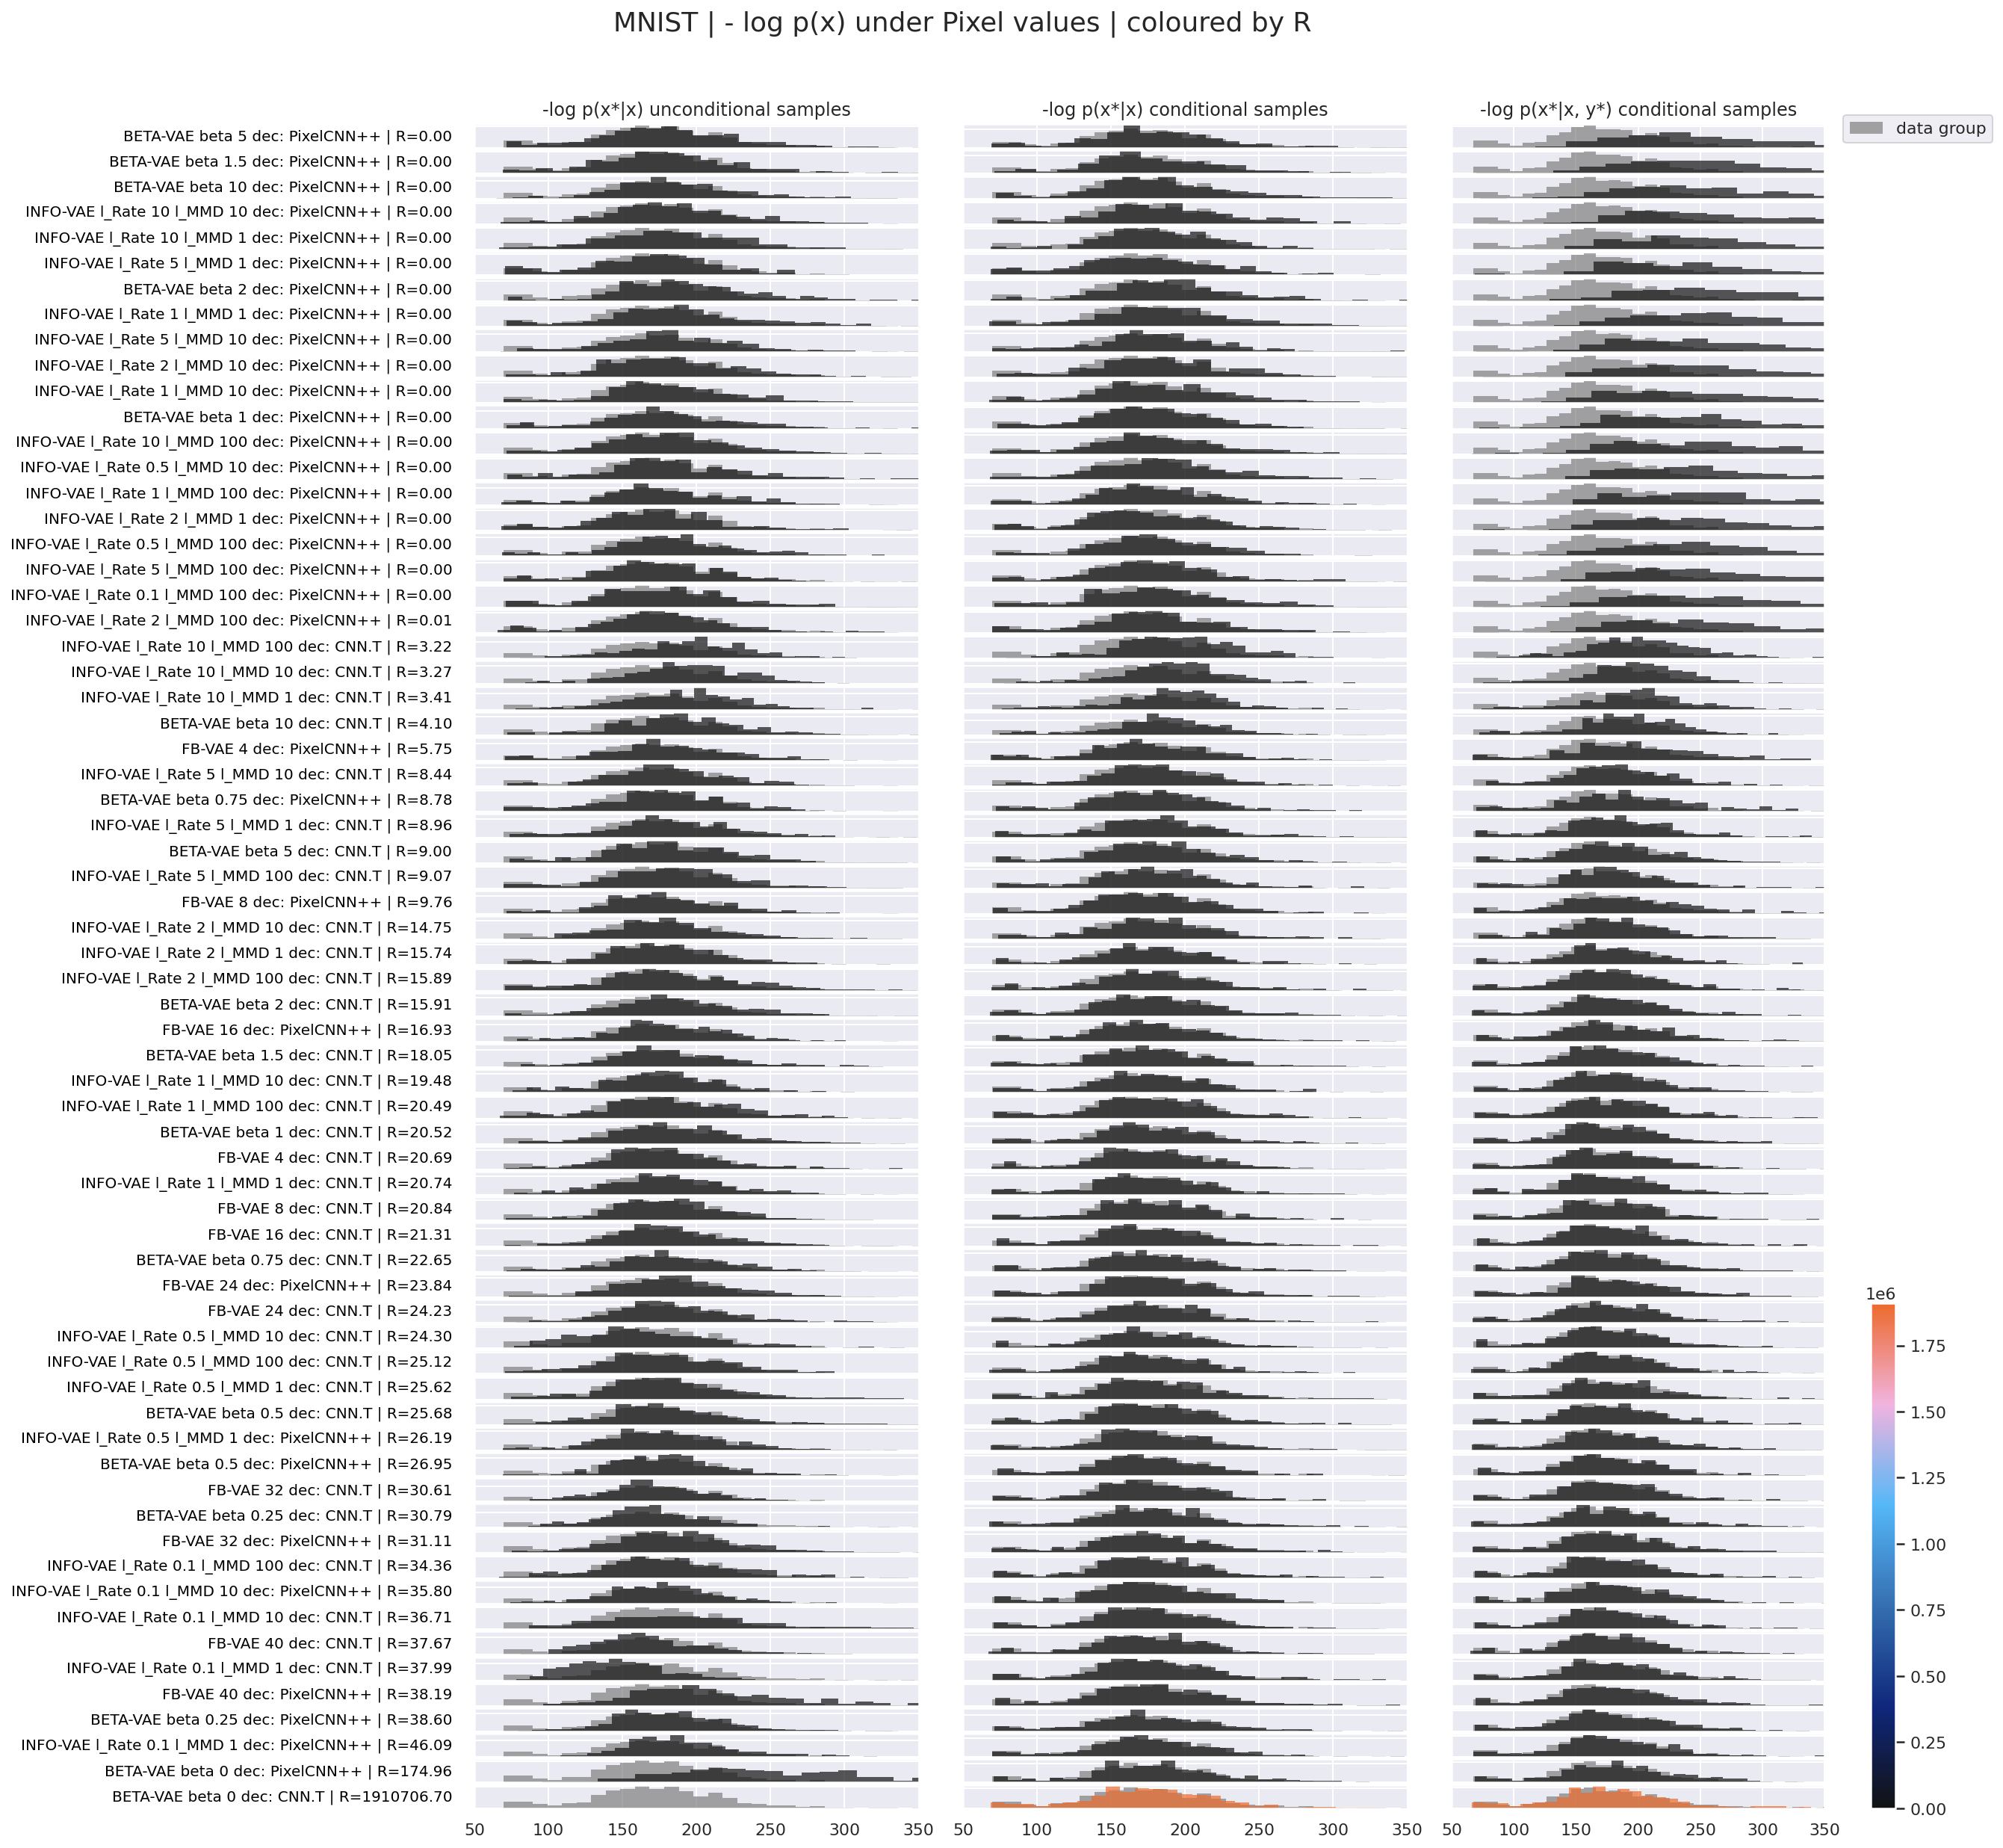

In [12]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="R", 
                                         bins=30,
                                         cm_shrink=0.3,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None,
                                         sort_ascend=True, 
                                         row_height=0.25)

Rows: 66, cols: 3, every: 1, n_groups: 66


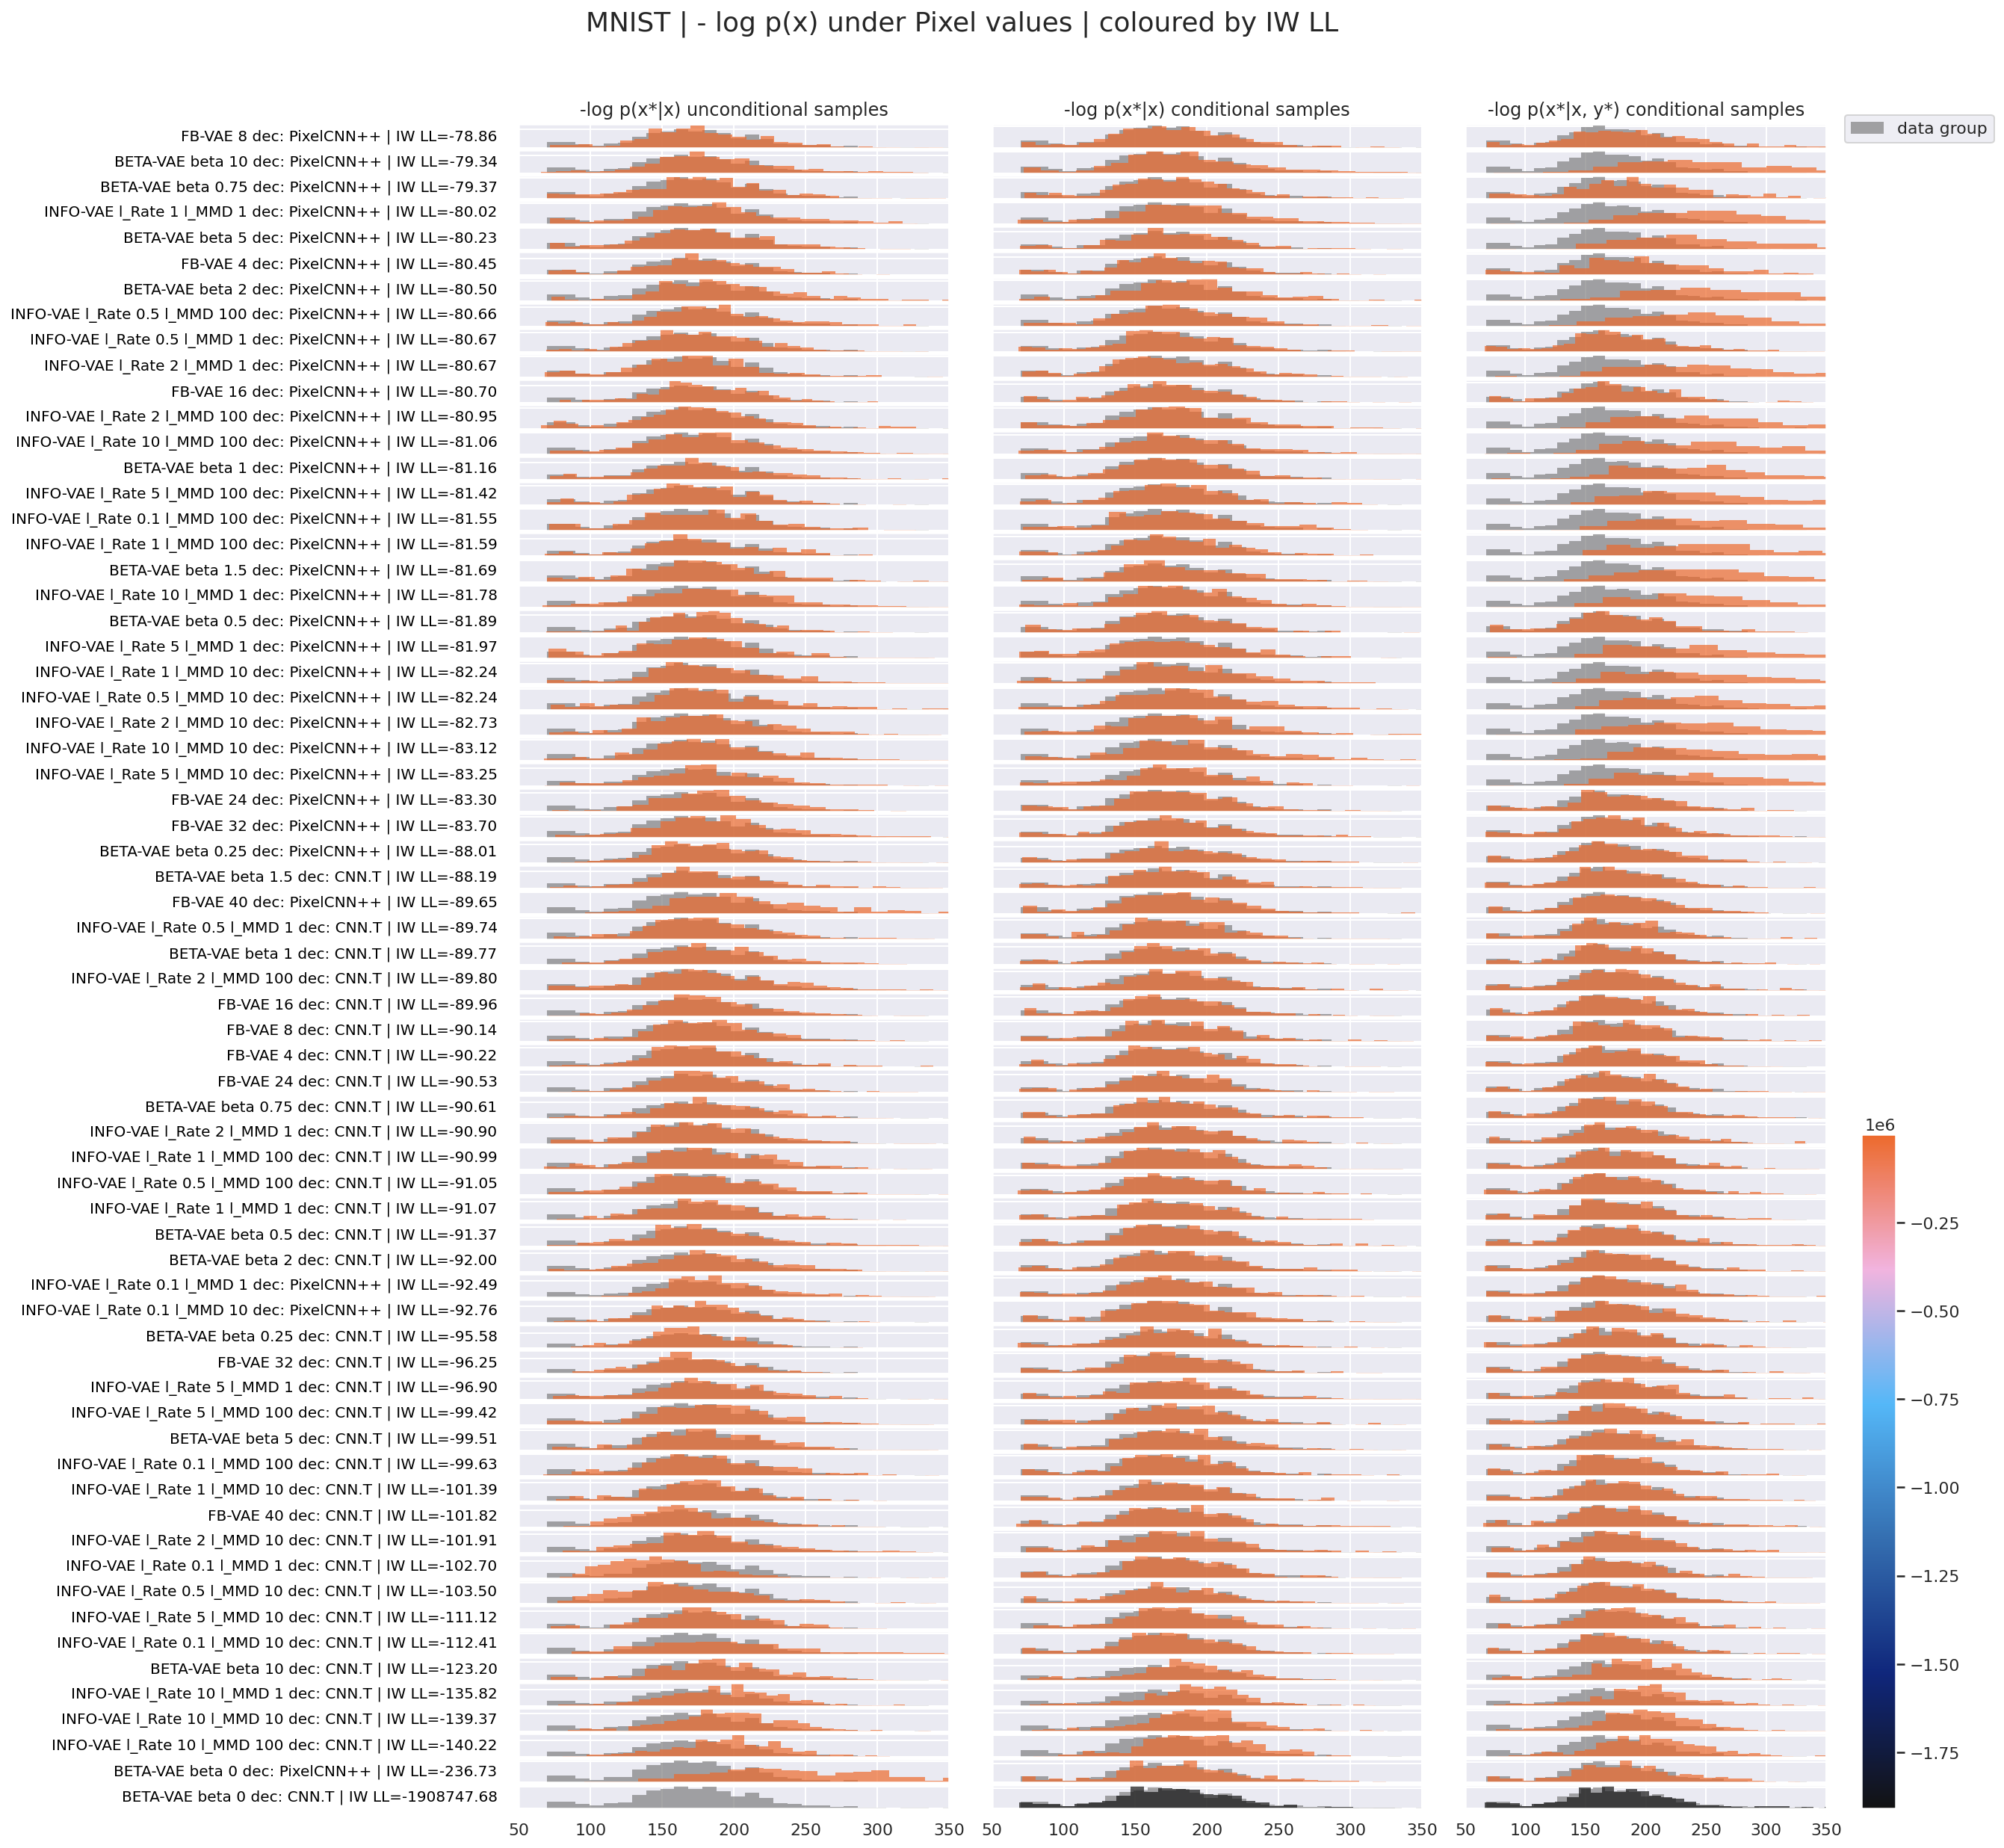

In [14]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="IW LL", 
                                         bins=30,
                                         cm_shrink=0.4,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None,
                                         sort_ascend=False, 
                                         row_height=0.25)